In [31]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
import seaborn as sns

from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']


# Load data


In [2]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

# Parameters needed for CV

In [3]:
no_iterations = 100
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'period'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  

no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

# Functions

In [14]:
def find_net_benefit(y_probabilities, y_true, omega_sequences, threshold_sequences):   
    net_benefit_by_omega = {}
    for omega in omega_sequences:
        net_benefit_thresholds = []
        for p in threshold_sequences:
            y_predict_test = np.where(y_probabilities[:, 1] > p, 1, 0)

            tn, fp, fn, tp = confusion_matrix(y_true=y_true, y_pred=y_predict_test).ravel()


            net_benefit = tp/(len(y_true)) - (fp/(len(y_true)) * omega)

            net_benefit_thresholds.append(net_benefit)
        net_benefit_by_omega[omega] =  net_benefit_thresholds  
    return net_benefit_by_omega

In [12]:
np.linspace(0,2,9)

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ])

# Naive dataset

In [4]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|beds_over_15_100k|weight").columns.tolist()
naive_data = HSA_weekly_data_all[columns_to_select]

In [15]:
weeks_to_predict = range(1, 123 - size_of_test_dataset - 3 - train_weeks_for_initial_model)
ROC_by_week_naive_period = []
sensitivity_by_week_naive_period = []
specificity_by_week_naive_period = []
ppv_by_week_naive_period = []
npv_by_week_naive_period = []
accuracy_by_week_naive_period = []
norm_MCC_by_week_naive_period = []

ROC_by_week_naive_exact = []
sensitivity_by_week_naive_exact = []
specificity_by_week_naive_exact = []
ppv_by_week_naive_exact = []
npv_by_week_naive_exact = []
accuracy_by_week_naive_exact = []
norm_MCC_by_week_naive_exact = []

ROC_by_week_naive_shifted = []
sensitivity_by_week_naive_shifted = []
specificity_by_week_naive_shifted = []
ppv_by_week_naive_shifted = []
npv_by_week_naive_shifted = []
accuracy_by_week_naive_shifted = []
norm_MCC_by_week_naive_shifted = []



net_benefit_by_model_omega_p_period  = {}
net_benefit_by_model_omega_p_exact  = {}
net_benefit_by_model_omega_p_shifted  = {}


omega_sequences = np.linspace(0,2,9)
threshold_sequences = np.linspace(0,1,101)

size_of_test_dataset = 1
for prediction_week in weeks_to_predict:
    print(prediction_week)
    print(range(1 , int(prediction_week + train_weeks_for_initial_model) + 1))
    print(range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1))
    #period    

    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data_period(naive_data, no_weeks=range(1, int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data_period(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as is the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier( random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_period.append(accuracy_score(y_test_naive, y_pred))
    ROC_by_week_naive_period.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitvity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_period.append(sensitvity)
    specificity_by_week_naive_period.append(specificity)

    ppv_by_week_naive_period.append(ppv)
    npv_by_week_naive_period.append(npv)

    norm_MCC_by_week_naive_period.append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

    net_benefit_by_omega_week_period = find_net_benefit(y_pred_proba, y_test_naive, omega_sequences, threshold_sequences)
    net_benefit_by_model_omega_p_period.__setitem__(prediction_week, net_benefit_by_omega_week_period)

    #exact 
    X_train_naive, y_train_naive, weights_naive, missing_data_train_HSA = prep_training_test_data(naive_data, no_weeks = range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive, y_test_naive, weights_test_naive, missing_data_test_HSA = prep_training_test_data(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive = weights_naive[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive, y_train_naive, sample_weight=weights_naive)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive)
    y_pred_proba = clf_naive.predict_proba(X_test_naive)

    # Evaluate the accuracy of the model
    accuracy_by_week_naive_exact.append(accuracy_score(y_test_naive, y_pred))
    ROC_by_week_naive_exact.append(roc_auc_score(y_test_naive, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_naive, y_pred)

    sensitivity, specificity, ppv, npv = calculate_metrics(conf_matrix)
    sensitivity_by_week_naive_exact.append(sensitivity)
    specificity_by_week_naive_exact.append(specificity)

    ppv_by_week_naive_exact.append(ppv)
    npv_by_week_naive_exact.append(npv)
    norm_MCC_by_week_naive_exact.append((matthews_corrcoef(y_test_naive, y_pred) + 1)/2)

    net_benefit_by_omega_week_exact = find_net_benefit(y_pred_proba, y_test_naive, omega_sequences, threshold_sequences)
    net_benefit_by_model_omega_p_exact.__setitem__(prediction_week, net_benefit_by_omega_week_exact)

    # shifted
    X_train_naive_shifted, y_train_naive_shifted, weights_naive_shifted, missing_data_train_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(1 , int(prediction_week + train_weeks_for_initial_model) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_naive_shifted, y_test_naive_shifted, weights_test_naive_shifted, missing_data_test_HSA = prep_training_test_data_shifted(naive_data, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_naive_shifted = weights_naive_shifted[0].to_numpy()
    # no hyperparameter tuning as it's the same irrespective of hyperparameters
    clf_naive = DecisionTreeClassifier(random_state=10, class_weight='balanced')
    clf_naive.fit(X_train_naive_shifted, y_train_naive_shifted, sample_weight=weights_naive_shifted)

    # Make predictions on the test set
    y_pred = clf_naive.predict(X_test_naive_shifted)
    y_pred_proba = clf_naive.predict_proba(X_test_naive_shifted)
    net_benefit_by_omega_week_shifted = find_net_benefit(y_pred_proba, y_test_naive_shifted, omega_sequences, threshold_sequences)
    net_benefit_by_model_omega_p_shifted.__setitem__(prediction_week, net_benefit_by_omega_week_shifted)     


1
range(1, 3)
range(3, 4)
2
range(1, 4)
range(4, 5)
3
range(1, 5)
range(5, 6)
4
range(1, 6)
range(6, 7)
5
range(1, 7)
range(7, 8)
6
range(1, 8)
range(8, 9)
7
range(1, 9)
range(9, 10)
8
range(1, 10)
range(10, 11)
9
range(1, 11)
range(11, 12)
10
range(1, 12)
range(12, 13)
11
range(1, 13)
range(13, 14)
12
range(1, 14)
range(14, 15)
13
range(1, 15)
range(15, 16)
14
range(1, 16)
range(16, 17)
15
range(1, 17)
range(17, 18)
16
range(1, 18)
range(18, 19)
17
range(1, 19)
range(19, 20)
18
range(1, 20)
range(20, 21)
19
range(1, 21)
range(21, 22)
20
range(1, 22)
range(22, 23)
21
range(1, 23)
range(23, 24)
22
range(1, 24)
range(24, 25)
23
range(1, 25)
range(25, 26)
24
range(1, 26)
range(26, 27)
25
range(1, 27)
range(27, 28)
26
range(1, 28)
range(28, 29)
27
range(1, 29)
range(29, 30)
28
range(1, 30)
range(30, 31)
29
range(1, 31)
range(31, 32)
30
range(1, 32)
range(32, 33)
31
range(1, 33)
range(33, 34)
32
range(1, 34)
range(34, 35)
33
range(1, 35)
range(35, 36)
34
range(1, 36)
range(36, 37)
35
range(

In [29]:
num_shades = 120
blue_shades = []

# Generate the shades of blue
for i in range(num_shades):
    # Vary the blue component from 0 (dark) to 1 (full intensity)
    blue_intensity = i / (num_shades - 1)
    # Create the RGB color tuple with full blue intensity and no red or green
    color = (0, 0, blue_intensity)
    blue_shades.append(color)

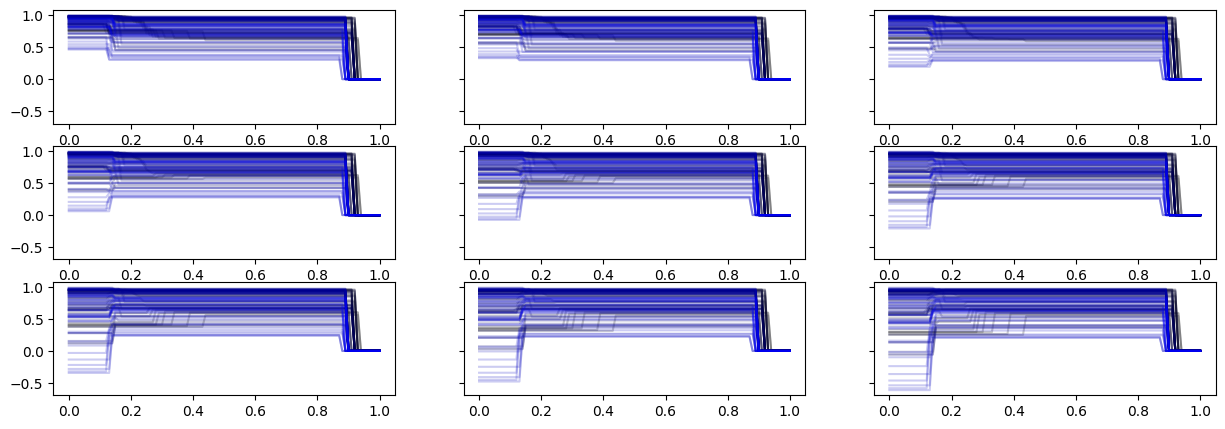

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 5), sharey = 'all')
axes = axes.ravel()
for i, omega in enumerate(omega_sequences):
        for week in weeks_to_predict:
            axes[i].plot(threshold_sequences, net_benefit_by_model_omega_p_period[week][omega], color = blue_shades[week], alpha=0.2)


In [114]:
heatmap_data_omega_0 = pd.DataFrame()
omega = omega_sequences[0]
for week in range( 1, weeks_to_predict[-1],1 ):
        weekly_data = net_benefit_by_model_omega_p_period[week][omega]
        weekly_data = weekly_data[::-1]
        heatmap_data_omega_0[week] = weekly_data

def get_heatmap_data_for_omega(NB_data, omega, weeks_to_predict):
        heatmap_data_omega = pd.DataFrame()
        for week in range( 1, weeks_to_predict[-1],1 ):
                weekly_data = NB_data[week][omega]
                weekly_data = weekly_data[::-1]
                heatmap_data_omega[week] = weekly_data
        return heatmap_data_omega


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16495/2685266758.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega_0[week] = weekly_data


Text(0.5, 1.0, 'Penalty = 0.0')

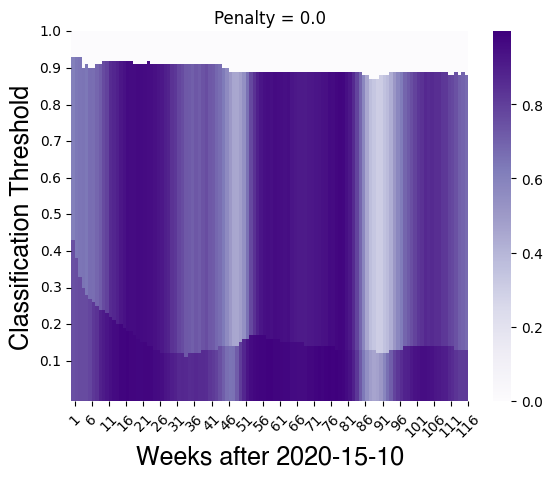

In [113]:
heatmap = sns.heatmap(heatmap_data_omega_0, annot=False, cmap='Purples')
heatmap.set_yticks(range(0, 91, 10))
y_labels = [str(round(0.1 * i,1)) for i in range(1, 11)][::-1] # Example x-axis labels
heatmap.set_yticklabels(y_labels)


heatmap.set_xticks(range(1, 120, 5))
x_labels = range(1, 120, 5) 
heatmap.set_xticklabels(x_labels, rotation=45)  # Rotation to 0 degrees

plt.xlabel('Weeks after 2020-15-10',**hfont,  fontsize = 18)
plt.ylabel("Classification Threshold",**hfont,  fontsize = 18)
plt.title(f'Penalty = {omega}')


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16495/2685266758.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16495/2685266758.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  heatmap_data_omega[week] = weekly_data
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_16495/2685266758.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many time

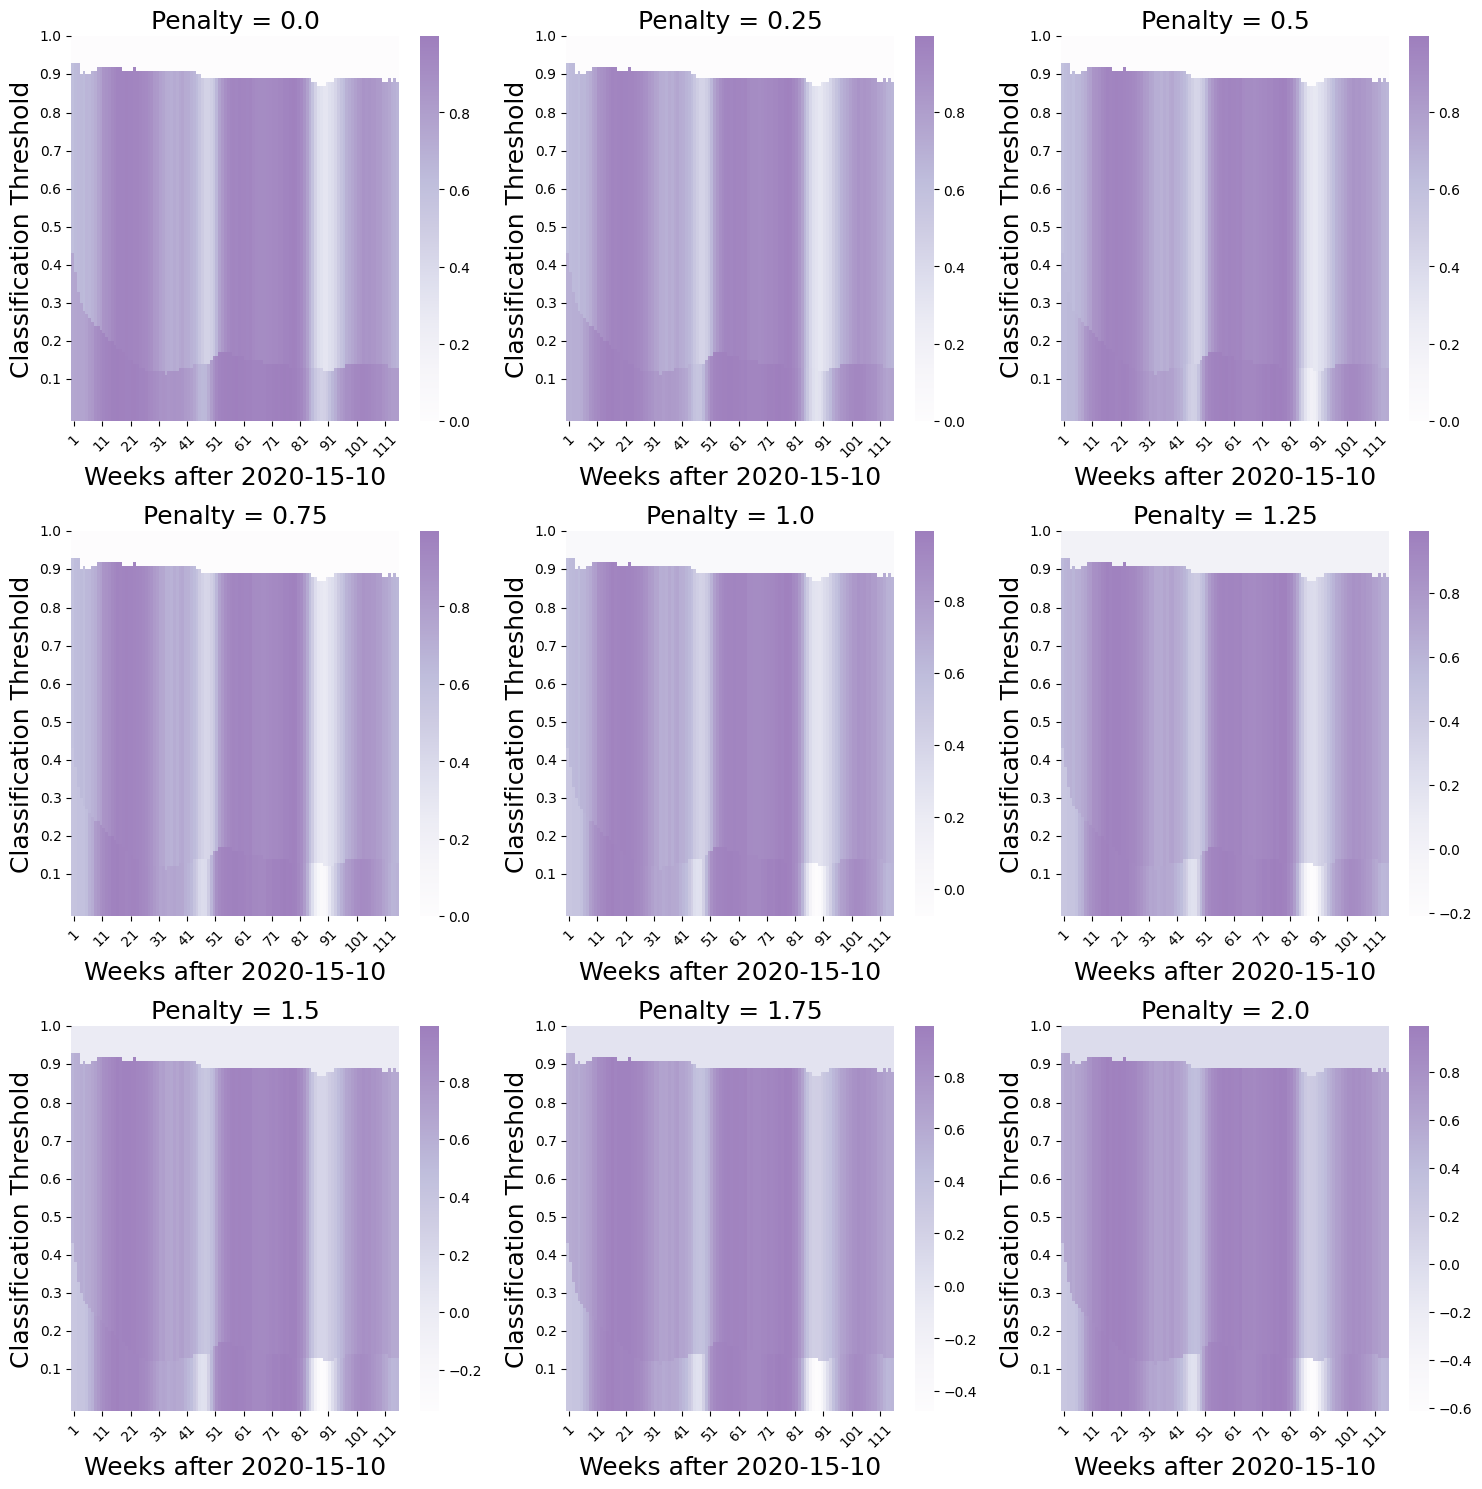

In [120]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Iterate over omega values and create a heatmap for each
for i, omega in enumerate(omega_sequences):
    row, col = divmod(i, 3)  # Calculate row and column indices
    ax = axes[row, col]  # Get the current subplot
    
    # Create the heatmap for the current omega value
    heatmap_data = get_heatmap_data_for_omega(net_benefit_by_model_omega_p_period, omega, weeks_to_predict);  # Replace with your actual data retrieval function
    sns.heatmap(heatmap_data, annot=False, cmap='Purples', ax=ax, alpha = 0.5) #  vmin=-1, vmax=1)
    ax.set_yticks(range(0, 91, 10))
    y_labels = [str(round(0.1 * i, 1)) for i in range(1, 11)][::-1]
    ax.set_yticklabels(y_labels)
    ax.set_xticks(range(1, 120, 10))
    x_labels = range(1, 120, 10)
    ax.set_xticklabels(x_labels, rotation=45)
    
    ax.set_xlabel('Weeks after 2020-15-10', fontsize=18)
    ax.set_ylabel("Classification Threshold", fontsize=18)
    ax.set_title(f'Penalty = {omega}', fontsize=18)

# Adjust the spacing between subplots
plt.tight_layout()


# Full classifier

In [126]:
new_directory = '/Users/rem76/Documents/COVID_projections/Expanding_training_set/'
os.chdir(new_directory)
net_benefit_by_omega_p_full_period = {}
weeks_to_predict_full  = range(1,35)
for prediction_week in weeks_to_predict_full:
    model_name_to_load = "Full_model_" + time_period + "_" + str(prediction_week) + ".sav"
    clf_full_period = pickle.load(open(model_name_to_load, 'rb'))

    X_train_full_period, y_train_full_period, weights_full_period, missing_data_train_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)

    X_test_full_period, y_test_full_period, weights_test_full_period, missing_data_test_HSA = prep_training_test_data_period(HSA_weekly_data_all, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=True)
    weights_full_period = weights_full_period[0].to_numpy()

    clf_full_period.fit(X_train_full_period, y_train_full_period, sample_weight=weights_full_period)

    # Make predictions on the test set
    y_pred_proba = clf_full_period.predict_proba(X_test_full_period)
    y_pred_positive_proba = y_pred_proba[:, 1] 
    net_benefit_by_omega_week_period = find_net_benefit(y_pred_proba, y_test_full_period, omega_sequences, threshold_sequences)
    net_benefit_by_omega_p_full_period.__setitem__(prediction_week, net_benefit_by_omega_week_period)  

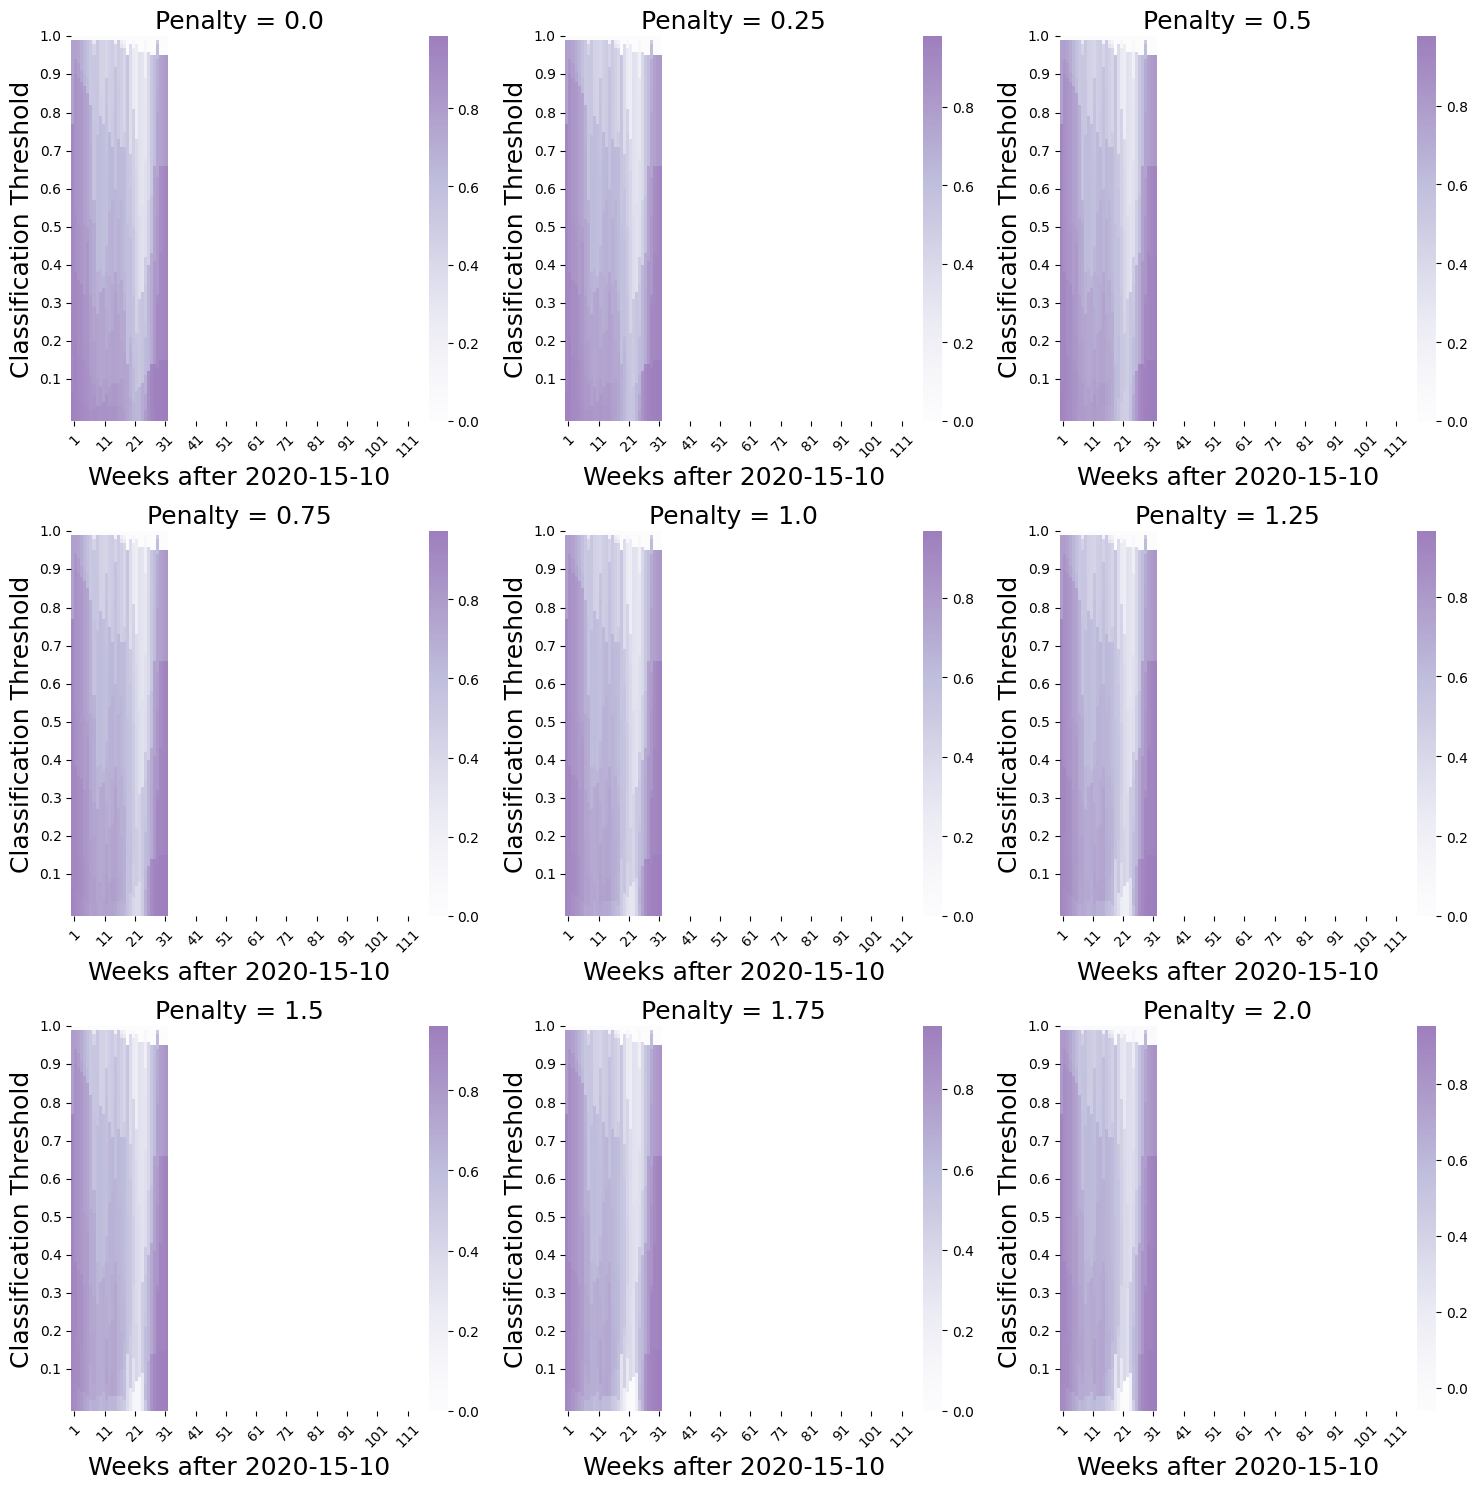

In [129]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
weeks_to_predict  = range(1,34)

# Iterate over omega values and create a heatmap for each
for i, omega in enumerate(omega_sequences):
    row, col = divmod(i, 3)  # Calculate row and column indices
    ax = axes[row, col]  # Get the current subplot
    
    # Create the heatmap for the current omega value
    heatmap_data = get_heatmap_data_for_omega(net_benefit_by_omega_p_full_period, omega, weeks_to_predict);  # Replace with your actual data retrieval function
    sns.heatmap(heatmap_data, annot=False, cmap='Purples', ax=ax, alpha = 0.5) #  vmin=-1, vmax=1)
    ax.set_yticks(range(0, 91, 10))
    y_labels = [str(round(0.1 * i, 1)) for i in range(1, 11)][::-1]
    ax.set_yticklabels(y_labels)
    ax.set_xticks(range(1, 120, 10))
    x_labels = range(1, 120, 10)
    ax.set_xticklabels(x_labels, rotation=45)
    
    ax.set_xlabel('Weeks after 2020-15-10', fontsize=18)
    ax.set_ylabel("Classification Threshold", fontsize=18)
    ax.set_title(f'Penalty = {omega}', fontsize=18)

# Adjust the spacing between subplots
plt.tight_layout()